<a href="https://colab.research.google.com/github/cjfghk5697/AjouDeeplearning_Compete/blob/main/baseline_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

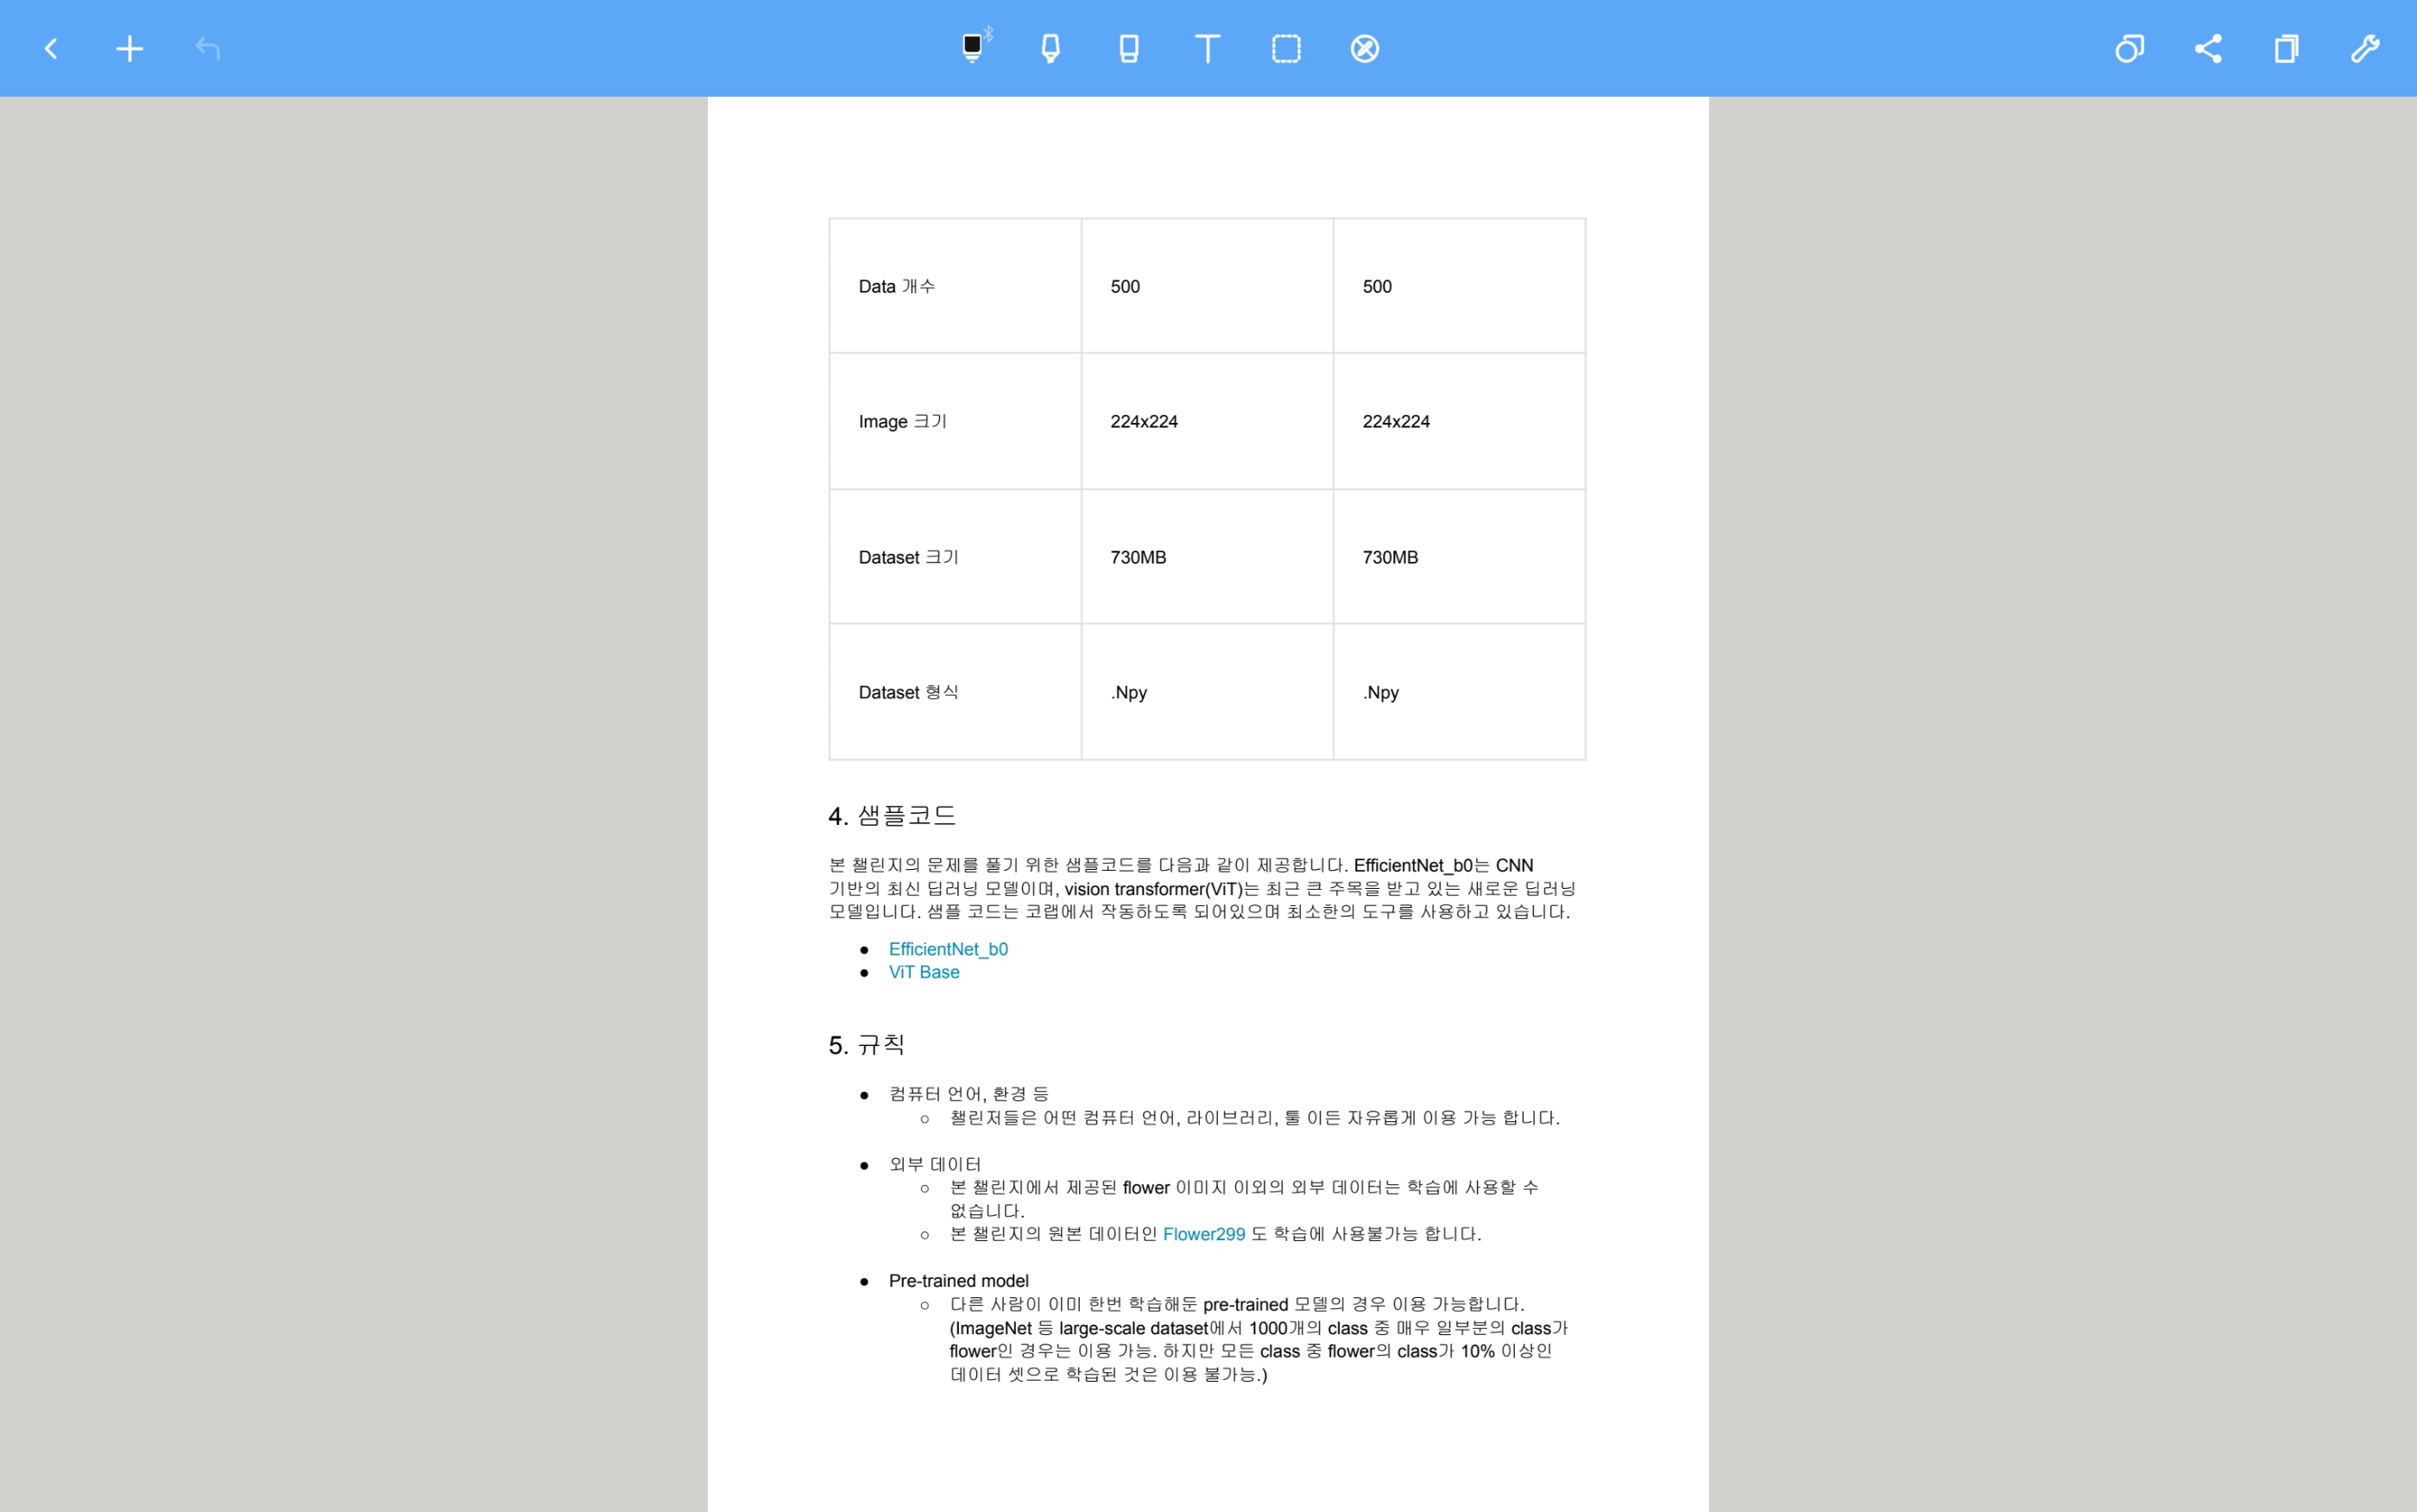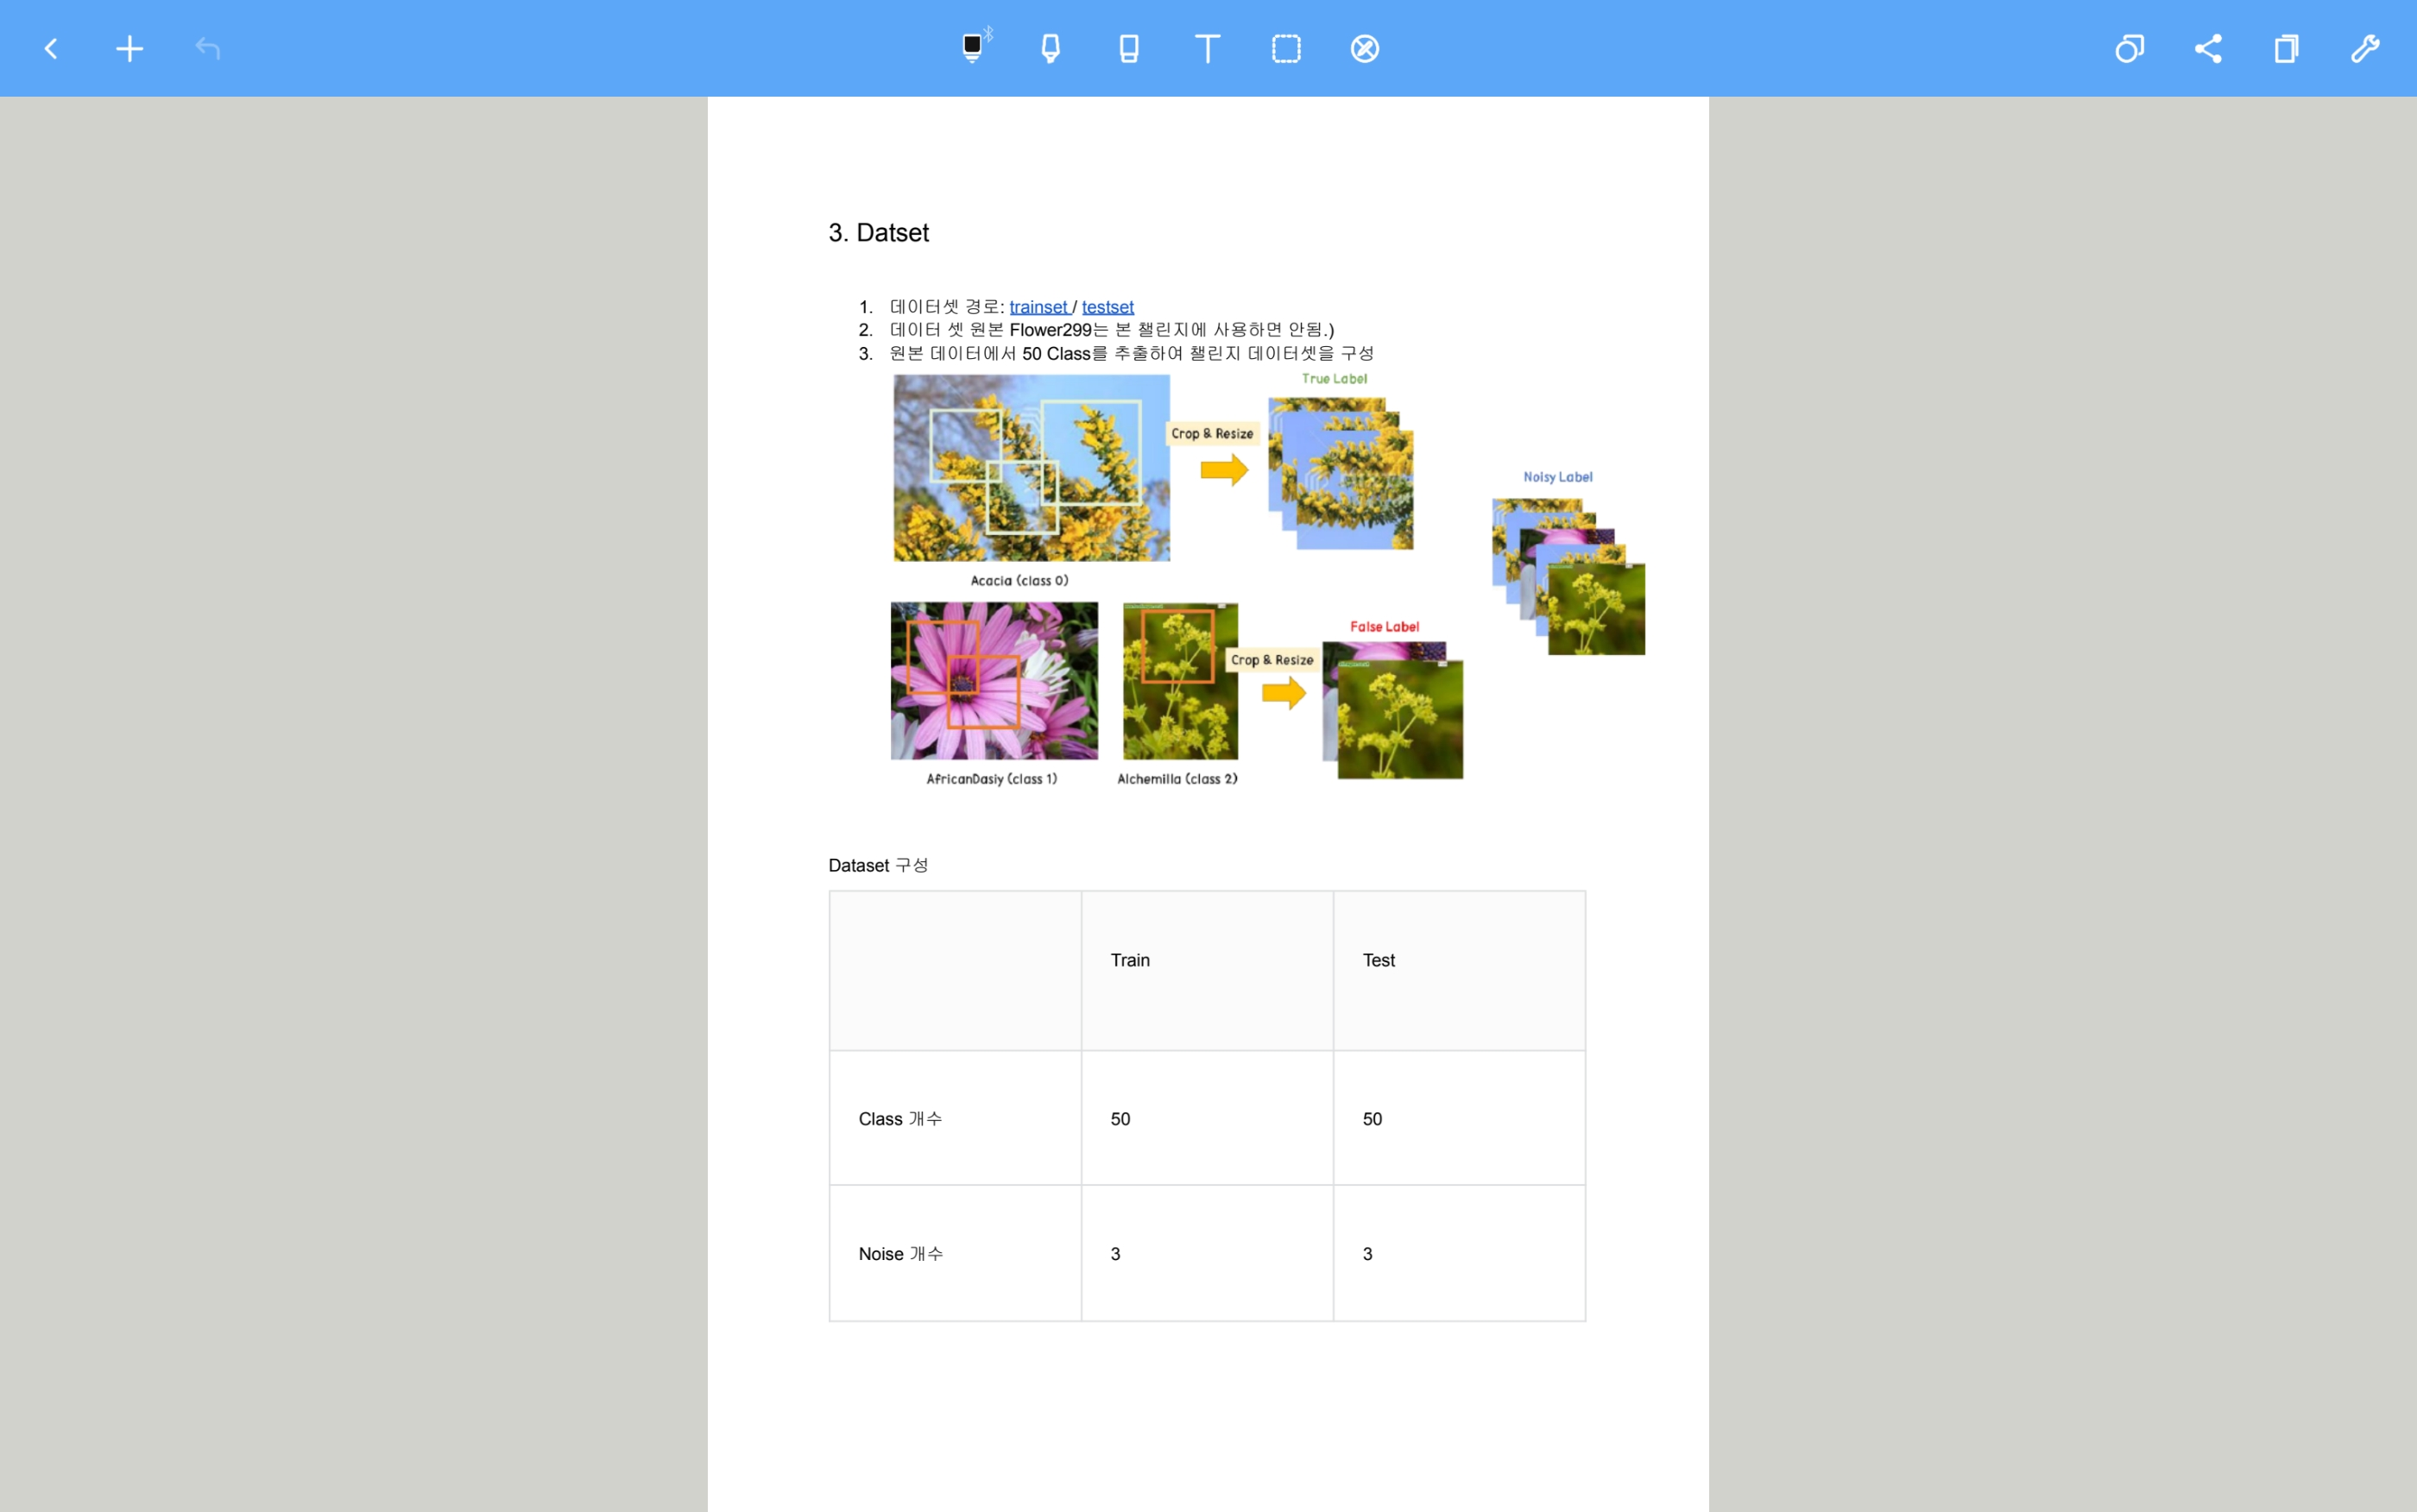

In [ ]:
!pip3 install timm
!pip3 install efficientnet_pytorch

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
import gdown
global PATH
import os
import time
import datetime
import logging
from pathlib import Path

from PIL import Image

from torch.utils.data.dataset import random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import pandas as pd

from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter

import timm
import numpy as np

from torch.utils.data import Dataset, DataLoader

from efficientnet_pytorch import EfficientNet


url_path_map = {
        'train': {
            'url':'https://drive.google.com/uc?id=1JewlmOsqs-O1EmMMKutcYYiD7GkN6brN', 
            'path':'dataset/train.npy'
            },
        'test': {
            'url':'https://drive.google.com/uc?id=1JcCFZbc_N7VIa3G3XA8grwz4XGdaaXSZ', 
            'path':'dataset/test.npy'
            },
        'label': {
            'url':'https://drive.google.com/uc?id=1JiaTOcZ6QfDThw3RrIa3ZxDDaNt-BMUQ',
            'path':'dataset/label_info.txt'
        }
    }


def download_dataset():
    Path('dataset').mkdir(exist_ok=True)
    for split in ['train', 'test', 'label']:
        if Path(url_path_map[split]['path']).exists():
            continue
        gdown.download(url_path_map[split]['url'], url_path_map[split]['path'], quiet=False)


def read_txt(file_name):
    with open(file_name, 'rt') as f:
        class_list = [row.strip('\n') for row in f.readlines()]
    return class_list


class MyDataset:
    def __init__(self, root, split='train', transform_fn=None, label='label_info'):
        self.dataset = np.load('{}/{}.npy'.format(root, split), allow_pickle=True).item()
        self.label_name = read_txt('{}/{}.txt'.format(root, label))
        self.transform_fn = transform_fn
        self.split = split
    
    @property
    def class_num(self):
        return len(self.label_name)
        
    def __len__(self):
        return len(self.dataset['label'])
    
    def __getitem__(self, idx):
        image, label = self.dataset['image'][idx], self.dataset['label'][idx]
        
        if self.transform_fn:
            image = self.transform_fn(image)
        
        return image, label

In [ ]:
class MnistModel_efficientb7(nn.Module):
    def __init__(self,model, in_channel=30, out_channel=3):
        super().__init__()
        self.model=model
        self.in_channel = in_channel
        self.dropout = nn.Dropout(p=0.2)
        self.conv0 = nn.Conv2d(in_channel, out_channel, kernel_size=(3, 3),padding=(1,1), stride=1)
        self.classifier = nn.Linear(512, 3)
        
    def forward(self, x):
        x = self.conv0(x)
        x = self.model(x)

        return x

In [ ]:
class MyModelWrapper:
    def __init__(self, log_name, model, criterion, optimizer, device):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.best_acc = 0
        self.setup_directory()
        self.log_name = '{}-{}'.format(datetime.datetime.now().strftime('%Y-%m-%d/%H-%M-%S'), log_name)
        self.log_best_weight_path = 'log/best_weight/{}.pth'.format(self.log_name)
        self.writer = SummaryWriter(log_dir='log/tensor_board/{}'.format(self.log_name), filename_suffix=log_name)
    
    def setup_directory(self):
        Path('log/tensor_board/{}'.format(datetime.datetime.now().strftime('%Y-%m-%d'))).mkdir(exist_ok=True, parents=True)
        Path('log/best_weight/{}'.format(datetime.datetime.now().strftime('%Y-%m-%d'))).mkdir(exist_ok=True, parents=True)
    
    def train(self, train_dl, epoch):
        debug_step = len(train_dl)//10
        batch_time = AverageMeter('Time', ':6.3f')
        data_time = AverageMeter('Data', ':6.3f')
        losses = AverageMeter('Loss', ':7.4f')
        top1 = AverageMeter('Acc@1', ':6.2f')
        top5 = AverageMeter('Acc@5', ':6.2f')
        progress = ProgressMeter(
            len(train_dl),
            [batch_time, data_time, losses, top1, top5],
            prefix="TRAIN: [{}]".format(epoch))

        self.model.train()

        end = time.time()
        for step, (x, y) in enumerate(train_dl):
            data_time.update(time.time() - end)
            x, y = x.to(self.device), y.to(self.device)
            y_hat = self.model(x)
            loss = self.criterion(y_hat, y)

            acc1, acc5 = accuracy(y_hat, y, topk=(1, 5))
            losses.update(loss.item(), x.size(0))
            top1.update(acc1[0], x.size(0))
            top5.update(acc5[0], x.size(0))

            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

            batch_time.update(time.time() - end)
            end = time.time()

            if step != 0 and step % debug_step == 0:
                progress.display(step)
        return losses.avg, top1.avg

    @torch.no_grad()
    def valid(self, dl):
        debug_step = len(dl) // 10
        batch_time = AverageMeter('Time', ':6.3f')
        losses = AverageMeter('Loss', ':7.4f')
        top1 = AverageMeter('Acc@1', ':6.2f')
        top5 = AverageMeter('Acc@5', ':6.2f')
        progress = ProgressMeter(
            len(dl),
            [batch_time, losses, top1, top5],
            prefix='VALID: ')

        self.model.eval()

        end = time.time()
        for step, (x, y) in enumerate(dl):
            x, y = x.float().to(self.device), y.long().to(self.device)
            y_hat = self.model(x)
            loss = F.cross_entropy(y_hat, y)

            acc1, acc5 = accuracy(y_hat, y, topk=(1, 5))
            losses.update(loss.item(), x.size(0))
            top1.update(acc1[0], x.size(0))
            top5.update(acc5[0], x.size(0))

            batch_time.update(time.time() - end)
            end = time.time()

            if step % debug_step == 0:
                progress.display(step)

        return losses.avg, top1.avg
    
    def fit(self, train_dl,valid_dl, nepoch=40):
        best_acc = 0
        best_acc_arg = 0

        for epoch in range(nepoch):
            train_loss, train_acc = self.train(train_dl, epoch)
            valid_loss, valid_acc = self.train(valid_dl, epoch)
          
            if valid_acc > best_acc:
                best_acc = valid_acc
                best_acc_arg = epoch + 1
                self.save_best_weight(self.model, best_acc)

            print('=' * 150)
            print(
                '[EPOCH]: {:03d}/{:03d}    train loss {:07.4f} acc {:07.4f}% ('
                'best accuracy : {:07.4f} @ {:03d})'.format(
                    epoch + 1, nepoch, valid_loss, valid_acc, best_acc,
                    best_acc_arg
                ))
            print('=' * 150)
            self.log_tensorboard(epoch, valid_loss, valid_acc)

    def save_best_weight(self, model, top1_acc):
        global PATH
        if top1_acc > self.best_acc:
            self.best_acc = top1_acc
            print('Saving best model({:07.4f}%) weight to {}'.format(top1_acc, self.log_best_weight_path))
            torch.save({'weight':model.state_dict(), 'top1_acc':top1_acc}, self.log_best_weight_path)
            PATH=self.log_best_weight_path
    def log_tensorboard(self, epoch, train_loss, train_acc):
        self.writer.add_scalar('Loss/train', train_loss, epoch)
        self.writer.add_scalar('Accuracy/train', train_acc, epoch)

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


In [ ]:
!CUDA_LAUNCH_BLOCKING=1

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

def get_model(model_name, n_classes=50, pretrained=True):
    model = timm.create_model("efficientnet_b5", pretrained=True, num_classes=n_classes)

    return MnistModel_efficientb7(model=model)


def run(model_name='cnn', lr=1e-3, batch_size=8, nepoch=50):
    # step 0. download dataset
    download_dataset()

    # step 1. load dataset
    train_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomRotation(180, expand=False),
        transforms.Resize((456, 456)), 
        transforms.Normalize((0.485, 0.456, 0.406)*10, (0.229, 0.224, 0.225)*10),
    ])  
    
    test_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((456, 456)), 
        transforms.Normalize((0.485, 0.456, 0.406)*10, (0.229, 0.224, 0.225)*10),
    ])
    
    train = MyDataset('dataset', 'train', train_transforms)
    test = MyDataset('dataset', 'test', test_transforms)
    
    train_size = int(0.8 * len(train))
    valid_size = len(train)-train_size

    train_dataset, val_dataset = random_split(train,[train_size,valid_size])

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size, num_workers=4)
    valid_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size,num_workers=4)
    test_loader = torch.utils.data.DataLoader(dataset=test, shuffle=True, batch_size=batch_size, num_workers=4)
    
    # step 2. load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = get_model(model_name).to(device)
    
    # step 3. prepare training tool
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
    
    # step 4. train model
    model = MyModelWrapper(model_name, model=model, device=device, optimizer=optimizer, criterion=criterion)
    model.fit(train_loader,valid_loader, nepoch=nepoch)
run()

No pretrained weights exist for this model. Using random initialization.


TRAIN: [0][ 5/50]	Time  0.846 ( 1.201)	Data  0.030 ( 0.264)	Loss  4.8371 ( 6.7947)	Acc@1   0.00 (  2.08)	Acc@5   0.00 (  8.33)
TRAIN: [0][10/50]	Time  0.859 ( 1.041)	Data  0.023 ( 0.155)	Loss  4.0182 ( 5.9765)	Acc@1   0.00 (  1.14)	Acc@5  25.00 (  9.09)
TRAIN: [0][15/50]	Time  0.840 ( 0.978)	Data  0.023 ( 0.114)	Loss  4.9244 ( 5.6772)	Acc@1   0.00 (  0.78)	Acc@5   0.00 (  7.81)
TRAIN: [0][20/50]	Time  0.845 ( 0.948)	Data  0.023 ( 0.093)	Loss  4.4932 ( 5.3648)	Acc@1   0.00 (  0.60)	Acc@5   0.00 (  8.93)
TRAIN: [0][25/50]	Time  0.877 ( 0.932)	Data  0.035 ( 0.081)	Loss  4.2147 ( 5.1772)	Acc@1   0.00 (  1.44)	Acc@5  12.50 (  9.62)
TRAIN: [0][30/50]	Time  0.843 ( 0.918)	Data  0.023 ( 0.072)	Loss  4.1082 ( 5.0110)	Acc@1   0.00 (  1.61)	Acc@5  12.50 ( 10.48)
TRAIN: [0][35/50]	Time  0.843 ( 0.908)	Data  0.023 ( 0.065)	Loss  4.1808 ( 4.8994)	Acc@1   0.00 (  1.39)	Acc@5  12.50 ( 10.76)
TRAIN: [0][40/50]	Time  0.839 ( 0.902)	Data  0.023 ( 0.060)	Loss  4.3853 ( 4.8286)	Acc@1   0.00 (  1.22)	Acc@5 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model('cnn')
model.load_state_dict(torch.load(PATH)['weight'])
model.to(device)
model.eval()

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((456, 456)),
    transforms.Normalize((0.485, 0.456, 0.406)*10, (0.229, 0.224, 0.225)*10),
])

test = MyDataset('dataset', 'test', test_transforms)
test_loader = torch.utils.data.DataLoader(dataset=test, shuffle=False, batch_size=4, num_workers=4)

No pretrained weights exist for this model. Using random initialization.


In [ ]:
sample_submission = pd.read_csv("/content/dataset/sample_submission.csv")
probs_array = np.zeros([sample_submission.shape[0],
                              sample_submission.shape[1] -1])

In [ ]:
batch_size=4

for idx,data in enumerate(test_loader):
    images, labels = data
    images, labels = images.cuda(), labels.cuda()
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)
    predictions= torch.reshape(predictions,(-1,1))
    batch_index=batch_size*idx
    probs_array[batch_index:batch_index+batch_size]= predictions.cpu()

In [ ]:
sample_submission.iloc[:,1:] = probs_array
sample_submission=sample_submission.astype(int)
sample_submission.to_csv('efficientNet.csv',index = False) # 경로 수정 필요